In [15]:
from juliacall import Main as jl, convert as jlconvert  # type: ignore

jl.seval("import Pkg")
jl.seval('Pkg.add("MixedModels")')
jl.seval('Pkg.add("DataFrames")')
jl.seval("using MixedModels")
jl.seval("using DataFrames")

from collections import defaultdict  # noqa: E402
from pathlib import Path  # noqa: E402
import numpy as np  # noqa: E402
import pandas as pd  # noqa: E402
import matplotlib.pyplot as plt  # noqa: E402
import seaborn as sns  # noqa: E402
import notebooks.notebook_utils as nu  # noqa: E402
from statannotations.Annotator import Annotator  # noqa: E402


def run_model(df, formula):
    """pd_to_df is a Julia function that takes a pd.DataFrame and turns it into a Julia DataFrame"""
    jl.j_df = jlconvert(jl.PyTable, df)
    jl.seval(f"j_formula = @formula({formula})")
    jl.seval("j_model = fit(MixedModel, j_formula, j_df, progress=false)")

    return jl.j_model


def comparisons(model_dfs, model_1_name, model_2_name, formula, query=None):
    model_1 = model_dfs[model_1_name]
    model_2 = model_dfs[model_2_name]
    model_comparison = pd.concat([model_1, model_2], axis=0, ignore_index=True)
    if query:
        model_comparison = model_comparison.query(query)

    return run_model(model_comparison, formula=formula)

   Resolving package versions...
  No Changes to `~/miniforge3/envs/decoding/julia_env/Project.toml`
  No Changes to `~/miniforge3/envs/decoding/julia_env/Manifest.toml`
   Resolving package versions...
  No Changes to `~/miniforge3/envs/decoding/julia_env/Project.toml`
  No Changes to `~/miniforge3/envs/decoding/julia_env/Manifest.toml`


# Main Results Table

In [16]:
# Initialize a dictionary to store results
all_res = defaultdict(dict)

# Iterate over each model and its corresponding argument class
for model, model_name in nu.models.items():
    # Determine the trainer type based on the model
    trainer = "CondPredBase"
    if model in ["Dummy", "LRDiane", "LRAvgDWELL", "ReadingSpeed"]:
        trainer = "ML"

    # Define the data options and path
    data_options = ["NoReread"]
    data_path = "august06"

    # Iterate over each data option
    for data_ in data_options:
        # Read the results for the given data, model, and trainer
        res = nu.read_res(
            data=data_,
            model=model_name,
            trainer=trainer,
            data_path=data_path,
            wandb_job_type=f"hyperparameter_sweep_{model_name}",
            base_res_path="task_decoding",
            on_error="continue",
            base_path=Path("../"),
        )

        # Check if the results were found
        if res is None:
            print(f"{model} - {data_} not found")
            continue
        else:
            print(f"Found {model} - {data_}")

            # Process the prediction probabilities
            if res["prediction_prob"].dtype == "object":
                # Convert string representation of lists to actual lists
                preds = nu.convert_string_to_list(res["prediction_prob"])
                y_pred = np.array(preds).argmax(
                    axis=1
                )  # Get the class with the highest probability
            else:
                preds = res["prediction_prob"]
                y_pred = (preds > 0.5).astype(
                    int
                )  # Binary classification based on threshold 0.5

            # Add the predictions to the results DataFrame
            res["y_pred"] = y_pred

            # Store the results in the dictionary
            all_res[data_][model] = res

Found Dummy - NoReread
Found LRAvgDWELL - NoReread
Found LRDiane - NoReread
Found FSE - NoReread
Found RoBERTa-QEye-W - NoReread
Found MAG - NoReread
Found PLMAS - NoReread
Found Haller RNN - NoReread
Found BEyeLSTM - NoReread
Found Eyettention - NoReread
Found RoBERTa-QEye-F - NoReread
Found PostFusion - NoReread


In [17]:
# Define the metric name
metric_name = "accuracy"

# Initialize a list to store the metric values
metrics = []

# Iterate over the results
for data_, data_res in all_res.items():
    for model, res in data_res.items():
        for eval_type in ["test", "val"]:
            res_val = res[res["eval_type"] == eval_type]
            metric_val = nu.raw_res_to_metric(res=res_val)
            metric_val = metric_val[[metric_name]].T

            metric_val.index = pd.MultiIndex.from_tuples(
                [(model, data_)], names=["Model", "Data"]
            )
            metric_val["Eval Type"] = eval_type
            metrics.append(metric_val)

# Concatenate the metric values into a single DataFrame
res_df = (
    pd.concat(metrics)
    .swaplevel()
    .reset_index()
    .set_index(["Eval Type", "Data", "Model"])
    .sort_index(level=["Eval Type", "Data", "Model"], ascending=[False, True, True])
)

# Aggregate the results
regime = nu.aggregate_df(res_df, metric_name)

# Reorder rows
model_order = nu.models.keys()
regime.sort_index(level="Eval Type", inplace=True)
all_results = regime.reindex(model_order, level="Model")  # type: ignore
all_results.columns = all_results.columns.str.replace("Accuracy ", "")


# Display the results
display(all_results)

Eval Regime                          new item new subject  \
Eval Type Data     Model                                    
test      NoReread Dummy           50.0 ± 0.0  50.0 ± 0.0   
                   LRAvgDWELL      59.0 ± 1.2  58.9 ± 3.2   
                   LRDiane         62.4 ± 1.1  60.6 ± 4.5   
                   FSE             71.5 ± 1.9  61.0 ± 3.5   
                   RoBERTa-QEye-W  65.9 ± 2.0  63.2 ± 3.5   
                   MAG             52.1 ± 0.9  52.3 ± 1.3   
                   PLMAS           58.6 ± 1.3  59.5 ± 1.7   
                   Haller RNN      61.3 ± 2.5  61.5 ± 2.7   
                   BEyeLSTM        71.4 ± 2.8  61.6 ± 3.6   
                   Eyettention     55.8 ± 2.6  55.7 ± 3.6   
                   RoBERTa-QEye-F  74.7 ± 3.7  63.1 ± 4.1   
                   PostFusion      70.7 ± 3.5  62.2 ± 3.6   
val       NoReread Dummy           50.0 ± 0.0  50.0 ± 0.0   
                   LRAvgDWELL      58.9 ± 1.5  58.9 ± 3.3   
                   LRDiane         62.6 ± 0.9  60.6 ± 4.9   
                   FSE             73.2 ± 1.9  64.9 ± 3.2   
                   RoBERTa-QEye-W  66.3 ± 1.3  65.4 ± 3.4   
                   MAG             53.7 ± 0.6  53.5 ± 1.6   
                   PLMAS           59.1 ± 1.6  61.1 ± 2.2   
                   Haller RNN      62.5 ± 1.4  62.4 ± 3.4   
                   BEyeLSTM        72.3 ± 1.9  65.0 ± 4.0   
                   Eyettention     56.4 ± 2.4  56.6 ± 2.8   
                   RoBERTa-QEye-F  76.5 ± 3.6  64.8 ± 4.2   
                   PostFusion      72.8 ± 2.5  64.6 ± 4.3   

Eval Regime                       new item and subject         all  
Eval Type Data     Model                                            
test      NoReread Dummy                    50.0 ± 0.0  50.0 ± 0.0  
                   LRAvgDWELL               60.4 ± 3.9  59.0 ± 1.6  
                   LRDiane                  60.8 ± 5.0  61.5 ± 2.5  
                   FSE                      61.5 ± 4.9  65.9 ± 1.4  
                   RoBERTa-QEye-W           62.3 ± 4.0  64.4 ± 2.0  
                   MAG                      51.5 ± 1.2  52.1 ± 0.6  
                   PLMAS                    57.5 ± 2.7  59.0 ± 1.2  
                   Haller RNN               60.3 ± 5.2  61.3 ± 1.3  
                   BEyeLSTM                 62.2 ± 4.1  66.2 ± 2.1  
                   Eyettention              55.4 ± 5.8  55.8 ± 2.9  
                   RoBERTa-QEye-F           62.6 ± 5.1  68.5 ± 2.8  
                   PostFusion               61.4 ± 3.2  66.1 ± 2.6  
val       NoReread Dummy                    50.0 ± 0.0  50.0 ± 0.0  
                   LRAvgDWELL               60.4 ± 4.0  58.9 ± 1.7  
                   LRDiane                  61.0 ± 5.6  61.6 ± 2.6  
                   FSE                      65.1 ± 4.4  68.8 ± 1.7  
                   RoBERTa-QEye-W           64.1 ± 3.1  65.8 ± 1.7  
                   MAG                      52.6 ± 2.0  53.5 ± 0.7  
                   PLMAS                    58.6 ± 2.7  60.1 ± 1.4  
                   Haller RNN               61.4 ± 4.4  62.3 ± 1.7  
                   BEyeLSTM                 66.1 ± 3.9  68.5 ± 1.9  
                   Eyettention              58.6 ± 3.4  56.6 ± 1.7  
                   RoBERTa-QEye-F           65.9 ± 4.4  70.3 ± 2.3  
                   PostFusion               63.6 ± 5.7  68.4 ± 2.8

## Statistical Improvement Over Baseline

In [18]:
# load the data, TODO can merge with the above
model_dfs = {}
for model_name, model_path in nu.models.items():
    trainer = "CondPredBase"
    if model_name in ["Dummy", "LRDiane", "LRAvgDWELL", "ReadingSpeed"]:
        trainer = "ML"
    res = pd.read_csv(
        f"../task_decoding/+data=NoReread,+data_path=august06,+model={model_path},+trainer={trainer},trainer.wandb_job_type=hyperparameter_sweep_{model_path}/trial_level_test_results.csv",
        usecols=[
            "subjects",
            "items",
            "fold_index",
            "eval_regime",
            "is_correct",
            "eval_type",
            "label",
            "prediction_prob",
            "binary_prediction",
        ],
    )
    to_use_model_name = model_name if model_name != "LRAvgDWELL" else "A_LRAvgDWELL"
    res["model_name"] = to_use_model_name
    model_dfs[to_use_model_name] = res

    model_dfs[to_use_model_name].rename(
        columns={"subjects": "subject_id", "items": "unique_paragraph_id"}, inplace=True
    )

In [19]:
do_stats = True
if not do_stats:
    print("Skipping stats!")
else:
    random_effects_structure = "full"

    if random_effects_structure == "full":
        model_comparison_formula = "is_correct ~ model_name + (1 + model_name| subject_id) + (1 +model_name| unique_paragraph_id)"
    elif random_effects_structure == "simple":
        model_comparison_formula = (
            "is_correct ~ model_name + (1 | subject_id) + (1| unique_paragraph_id)"
        )

    import tqdm

    stat_output = []
    for model_name in tqdm.tqdm(nu.models.keys()):
        if model_name == "LRAvgDWELL":
            continue
        model_output = [model_name]
        for eval_regime in ["new_item", "new_subject", "new_item_and_subject", "all"]:
            final_formula = (
                model_comparison_formula + " + (1 | eval_regime)"  # type: ignore
                if eval_regime == "all"
                else model_comparison_formula
            )
            query = "(eval_type == 'test')"
            if eval_regime != "all":
                query += f" & (eval_regime == '{eval_regime}')"
            output = comparisons(
                model_dfs=model_dfs,
                model_1_name="A_LRAvgDWELL",
                model_2_name=model_name,
                formula=final_formula,
                query=query,
            )
            asterik_pvalue = (
                nu.map_pvalue_to_asterisks(4 * output.pvalues[1] / 4)
                if output.beta[1] > 0
                else ""
            )

            model_output.append(
                f"{round(output.beta[1]*100, 1)}±{round(1.96*output.stderror[1]*100, 1)}{asterik_pvalue}"
            )
        stat_output.append(model_output)
    stat_output_df = pd.DataFrame(
        stat_output,
        columns=[
            "Model",
            "New Item",
            "New Participant",
            "New Item and Participant",
            "All",
        ],
    )
    display(stat_output_df)

100%|██████████| 12/12 [01:44<00:00,  8.73s/it]


,Model,New Item,New Participant,New Item and Participant,All
0,Dummy,-9.0±3.6,-8.9±5.9,-10.4±6.3,-9.0±4.2
1,LRDiane,3.4±2.2**,1.7±2.3n.s.,0.3±3.1n.s.,2.4±2.2*
2,FSE,12.4±3.0***,2.1±3.3n.s.,1.1±4.2n.s.,6.9±3.1***
3,RoBERTa-QEye-W,6.7±2.5***,4.2±2.7**,2.1±3.6n.s.,5.3±2.5***
4,MAG,-6.9±3.3,-6.6±2.8,-8.9±4.7,-6.9±3.0
5,PLMAS,-0.4±2.1,0.5±2.5n.s.,-2.9±3.3,-0.1±2.2
6,Haller RNN,2.2±2.5n.s.,2.6±2.7n.s.,0.0±3.6n.s.,2.3±2.5n.s.
7,BEyeLSTM,12.4±2.9***,2.6±3.4n.s.,2.0±4.3n.s.,7.2±3.1***
8,Eyettention,-3.3±3.3,-3.2±3.5,-5.2±4.7,-3.4±3.3
9,RoBERTa-QEye-F,15.8±3.0***,4.2±3.2*,2.6±4.1n.s.,9.6±3.0***


## Baseline improvement over dummy, print actual pvalues

In [20]:
do_stats = True
if not do_stats:
    print("Skipping stats!")
else:
    random_effects_structure = "full"

    if random_effects_structure == "full":
        model_comparison_formula = "is_correct ~ model_name + (1 + model_name| subject_id) + (1 +model_name| unique_paragraph_id)"
    elif random_effects_structure == "simple":
        model_comparison_formula = (
            "is_correct ~ model_name + (1 | subject_id) + (1| unique_paragraph_id)"
        )

    import tqdm

    stat_output = []
    model_name = "Dummy"
    model_output = [model_name]
    for eval_regime in ["new_item", "new_subject", "new_item_and_subject", "all"]:
        final_formula = (
            model_comparison_formula + " + (1 | eval_regime)"  # type: ignore
            if eval_regime == "all"
            else model_comparison_formula
        )
        query = "(eval_type == 'test')"
        if eval_regime != "all":
            query += f" & (eval_regime == '{eval_regime}')"
        model_dfs_copy = model_dfs.copy()
        model_dfs_copy['Dummy'] = model_dfs_copy['Dummy']
        model_dfs_copy['Dummy']['model_name'] = 'AA_Dummy'
        model_dfs_copy['LRAvgDWELL'] = model_dfs_copy['A_LRAvgDWELL']
        output = comparisons(
            model_dfs=model_dfs_copy,
            model_1_name=model_name,
            model_2_name="LRAvgDWELL",
            formula=final_formula,
            query=query,
        )
        asterik_pvalue = (
            nu.map_pvalue_to_asterisks(4 * output.pvalues[1] / 4)
            # if output.beta[1] > 0
            # else ""
        )
        print(output)
        model_output.append(
            f"{round(output.beta[1]*100, 1)}±{round(1.96*output.stderror[1]*100, 1)}{asterik_pvalue}"
        )
        stat_output.append(model_output)
    stat_output_df = pd.DataFrame(
        stat_output,
        columns=[
            "Model",
            "New Item",
            "New Participant",
            "New Item and Participant",
            "All",
        ],
    )
    display(stat_output_df)

Linear mixed model fit by maximum likelihood
 is_correct ~ 1 + model_name + (1 + model_name | subject_id) + (1 + model_name | unique_paragraph_id)
    logLik   -2 logLik      AIC         AICc        BIC     
 -20482.2221  40964.4442  40982.4442  40982.4494  41058.6091

Variance components:
                             Column           Variance   Std.Dev.    Corr.
subject_id          (Intercept)               0.03510572 0.18736519
                    model_name: A_LRAvgDWELL  0.11498811 0.33909896 -0.39
unique_paragraph_id (Intercept)               0.00000000 0.00000000
                    model_name: A_LRAvgDWELL  0.00000000 0.00000177  +NaN
Residual                                      0.17808221 0.42199788
 Number of obs: 34988; levels of grouping factors: 360, 324

  Fixed-effects parameters:
────────────────────────────────────────────────────────────────
                              Coef.  Std. Error      z  Pr(>|z|)
───────────────────────────────────────────────────────────────

,Model,New Item,New Participant,New Item and Participant,All
0,Dummy,9.0±3.6***,8.9±5.9**,10.4±6.3**,9.0±4.2***
1,Dummy,9.0±3.6***,8.9±5.9**,10.4±6.3**,9.0±4.2***
2,Dummy,9.0±3.6***,8.9±5.9**,10.4±6.3**,9.0±4.2***
3,Dummy,9.0±3.6***,8.9±5.9**,10.4±6.3**,9.0±4.2***


# Correlation Analysis - Figure 3a

In [21]:
# Take the individual model results and make them wide
wide_results = (
    pd.concat(model_dfs, ignore_index=True)
    .pivot(
        index=[
            "subject_id",
            "unique_paragraph_id",
            "eval_regime",
            "fold_index",
            "eval_type",
        ],
        columns="model_name",
        values="prediction_prob",
    )
    .reset_index()
)

# Add the label (arbitrarily from MAG, should be the same in all)
wide_results = wide_results.merge(
    model_dfs["MAG"][
        [
            "subject_id",
            "unique_paragraph_id",
            "eval_regime",
            "fold_index",
            "label",
            "eval_type",
        ]
    ],
    on=["subject_id", "unique_paragraph_id", "eval_regime", "fold_index", "eval_type"],
    how="left",
    validate="one_to_one",
)

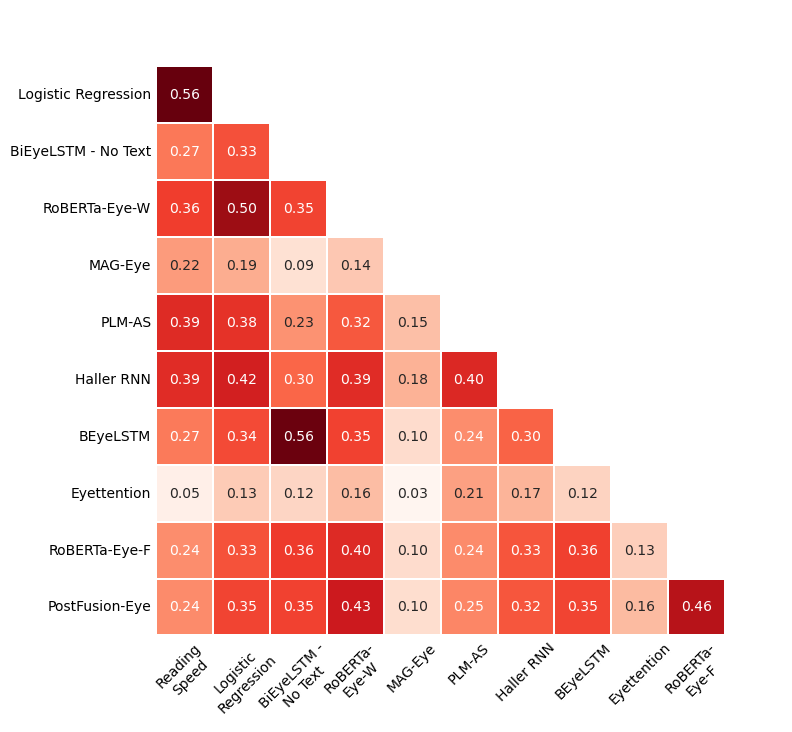

In [22]:
from sklearn.metrics import cohen_kappa_score


# Filter the DataFrame for the desired evaluation type
filtered_results = wide_results[wide_results["eval_type"] == "val"]

models_to_display = [
    # "label",
    # "Dummy",
    "A_LRAvgDWELL",
    "LRDiane",
    "FSE",
    "RoBERTa-QEye-W",
    "MAG",
    "PLMAS",
    "Haller RNN",
    "BEyeLSTM",
    "Eyettention",
    "RoBERTa-QEye-F",
    "PostFusion",
]

# Compute the correlation matrix for the selected models
# correlation_matrix = (
#     filtered_results[models_to_display]
#     .rename(columns={"A_LRAvgDWELL": "LRAVgDWELL"})
#     .corr()
# )
# Initialize an empty DataFrame to store the matching scores
correlation_matrix = pd.DataFrame(index=models_to_display, columns=models_to_display)

# Compute the matching score for each pair of models
for model1 in models_to_display:
    for model2 in models_to_display:
        # Calculate the matching score as the proportion of matching values (0 or 1)
        # matching_score = (filtered_results[model1].round() == filtered_results[model2].round()).mean()
        # correlation_matrix.loc[model1, model2] = matching_score

        kappa_score = cohen_kappa_score(
            filtered_results[model1].round(), filtered_results[model2].round()
        )
        correlation_matrix.loc[model1, model2] = kappa_score

# Convert the matching scores to float
correlation_matrix = correlation_matrix.astype(float)

# Calculate the average correlation for each model with the other models
# average_correlation = correlation_matrix.mean(axis=1)

# # Order the models by their average correlation
# correlation_matrix = correlation_matrix.loc[average_correlation.sort_values(ascending=False).index]
# correlation_matrix = correlation_matrix[average_correlation.sort_values(ascending=False).index]

# Display the ordered correlation matrix

# Order the models by their correlation with the label both columns and rows
# correlation_matrix = correlation_matrix.sort_values("label", ascending=False)
# correlation_matrix = correlation_matrix[correlation_matrix.index]
corr_matrix_mappings = {
    "index": {
        "label": "Ground Truth Label",
        "LRAvgDWELL": "Reading Speed",
        "A_LRAvgDWELL": "Reading Speed",
        "RoBERTa-QEye-W": "RoBERTa-Eye-W",
        "RoBERTa-QEye-F": "RoBERTa-Eye-F",
        "FSE": "BiEyeLSTM - No Text",
        "LRDiane": "Logistic Regression",
        "PLMAS": "PLM-AS",
        "PostFusion": "PostFusion-Eye",
        "MAG": "MAG-Eye",
    },
    "columns": {
        "label": "Ground Truth\nLabel",
        "LRAVgDWELL": "Reading\nSpeed",
        "A_LRAvgDWELL": "Reading\nSpeed",
        "RoBERTa-QEye-W": "RoBERTa-\nEye-W",
        "RoBERTa-QEye-F": "RoBERTa-\nEye-F",
        "FSE": "BiEyeLSTM -\nNo Text",
        "LRDiane": "Logistic\nRegression",
        "PLMAS": "PLM-AS",
        "MAG": "MAG-Eye",
        "PostFusion": "PostFusion-\nEye",
    },
}
# Replace "label" with "Ground Truth Label"
correlation_matrix = correlation_matrix.rename(
    index=corr_matrix_mappings["index"],
    columns=corr_matrix_mappings["columns"],
)


# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=0)

cmap = sns.color_palette("Reds", as_cmap=True)


# cmap = sns.diverging_palette(230, 20, as_cmap=True)


# Plot the heatmap
plt.figure(figsize=(8, 8))

# Get the current xticklabels
xticklabels = correlation_matrix.columns.tolist()
# Remove "PostFusion-Eye" from the xticklabels
xticklabels = [label for label in xticklabels if label != "PostFusion-\nEye"]

# Get the current yticklabels
yticklabels = correlation_matrix.index.tolist()
# Remove "Reading Speed" from the yticklabels
yticklabels = [label if label != "Reading Speed" else "" for label in yticklabels]

# Plot the heatmap with the modified xticklabels and yticklabels
ax = sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cbar=False,
    square=True,
    cmap=cmap,
    mask=mask,
    linewidths=0.25,
    xticklabels=xticklabels,
    yticklabels=yticklabels,
)
ax.tick_params(axis="both", which="both", length=0)

# Set the title and rotate x-axis labels
# plt.title("Correlation Matrix for Selected Models")
plt.xticks(rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("figures/model_correlation.pdf")
plt.show()

## Correlation matrix appendix Figure

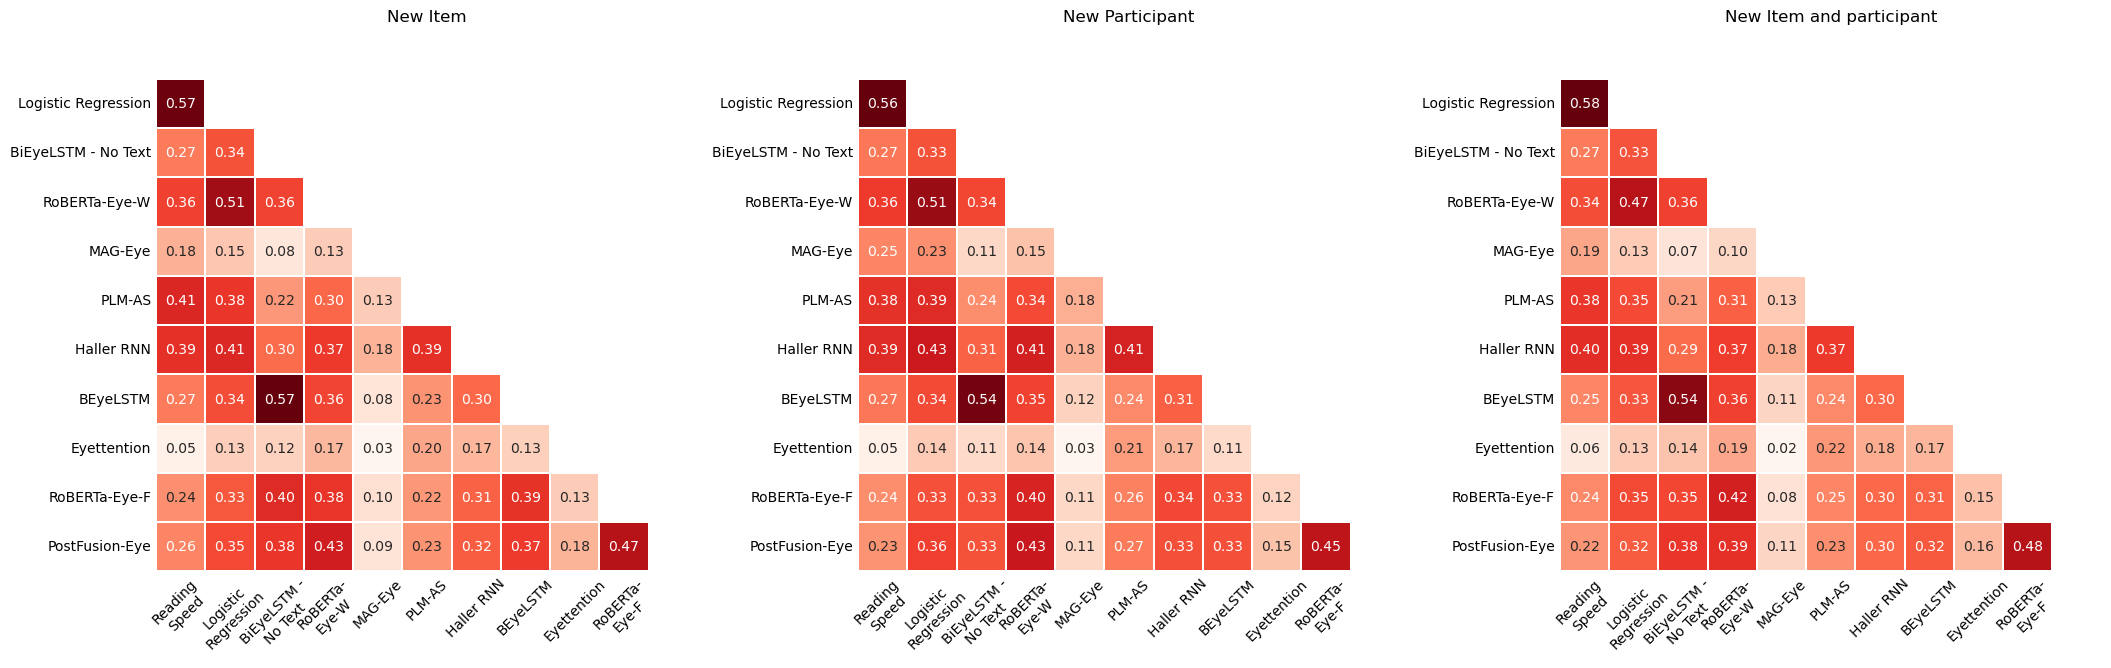

In [23]:
unique_eval_regimes = wide_results["eval_regime"].unique()
num_regimes = len(unique_eval_regimes)

# Create subplots
fig, axes = plt.subplots(
    1,
    num_regimes,
    figsize=(7 * num_regimes, 7),
    constrained_layout=True,
    # sharey=True
)


for i, regime in enumerate(unique_eval_regimes):
    # Filter the DataFrame for the desired evaluation type
    filtered_results = wide_results[
        (wide_results["eval_regime"] == regime) & (wide_results["eval_type"] == "val")
    ]

    correlation_matrix = pd.DataFrame(
        index=models_to_display, columns=models_to_display
    )

    # Compute the matching score for each pair of models
    for model1 in models_to_display:
        for model2 in models_to_display:
            # Calculate the matching score as the proportion of matching values (0 or 1)
            # matching_score = (filtered_results[model1].round() == filtered_results[model2].round()).mean()
            # correlation_matrix.loc[model1, model2] = matching_score

            kappa_score = cohen_kappa_score(
                filtered_results[model1].round(), filtered_results[model2].round()
            )
            correlation_matrix.loc[model1, model2] = kappa_score

    # Convert the matching scores to float
    correlation_matrix = correlation_matrix.astype(float)

    # Compute the correlation matrix for the selected models
    # correlation_matrix = (
    #     filtered_results[models_to_display]
    #     .rename(columns={"A_LRAvgDWELL": "LRAVgDWELL"})
    #     .corr()
    # )

    # Order the models by their correlation with the label both columns and rows
    # correlation_matrix = correlation_matrix.sort_values("label", ascending=False)
    # correlation_matrix = correlation_matrix[correlation_matrix.index]

    # Replace "label" with "Ground Truth Label"
    correlation_matrix = correlation_matrix.rename(
        index=corr_matrix_mappings["index"],
        columns=corr_matrix_mappings["columns"],
    )

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=0)

    cmap = sns.color_palette("Reds", as_cmap=True)

    # cmap = sns.diverging_palette(230, 20, as_cmap=True)

    ax = axes[i] if num_regimes > 1 else axes

    # Get the current xticklabels
    xticklabels = correlation_matrix.columns.tolist()
    # Remove "PostFusion-Eye" from the xticklabels
    xticklabels = [label for label in xticklabels if label != "PostFusion-\nEye"]

    # Get the current yticklabels
    yticklabels = correlation_matrix.index.tolist()
    # Remove "Reading Speed" from the yticklabels
    yticklabels = [label if label != "Reading Speed" else "" for label in yticklabels]

    # Plot the heatmap with the modified xticklabels and yticklabels
    ax = sns.heatmap(
        correlation_matrix,
        annot=True,
        fmt=".2f",
        cbar=False,
        square=True,
        cmap=cmap,
        mask=mask,
        linewidths=0.25,
        xticklabels=xticklabels,
        yticklabels=yticklabels,
        ax=ax,
    )
    ax.tick_params(axis="both", which="both", length=0)
    regime_map = {
            "new_item": "New Item",
            "new_subject": "New Participant",
            "new_item_and_subject": "New Item and participant",
    }
    ax.set_title(f"{regime_map[regime]}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    # Set the title and rotate x-axis labels
    # plt.title("Correlation Matrix for Selected Models")
    # plt.xticks(rotation=45)

    # Adjust layout and show the plot
plt.savefig("figures/model_correlation_by_regime.pdf")
plt.show()

# Majority Vote

In [14]:
excluded_models = [
    "Dummy",
    "A_LRAvgDWELL",
    # "LRDiane",
    # "FSE",
    # "RoBERTa-QEye-W",
    # "MAG",
    # "PLMAS",
    # "Haller RNN",
    # "BEyeLSTM",
    # "Eyettention",
    # "RoBERTa-QEye-F",
    # "PostFusion",
]
tie_breaker_model = (
    "RoBERTa-QEye-F"  # TODO Take the model with the highest accuracy per fold?
)
# Assuming 'wide_results' is a DataFrame that contains the 'eval_regime' column
unique_eval_regimes = wide_results["eval_regime"].unique()

# Create a new DataFrame to store the majority vote results
majority_vote_results = wide_results.copy()

for i, regime in enumerate(unique_eval_regimes):
    # Filter the DataFrame for the current eval_regime
    regime_results = wide_results[wide_results["eval_regime"] == regime]
    # val_results = regime_results[regime_results["eval_type"] == "val"]
    # For each fold, compute the accuracy of each model and return the model with the highest accuracy:

    # Compute the correlation matrix for the current eval_regime
    raw_predictions = regime_results[list(model_dfs.keys() - excluded_models)]

    # # Take majority vote
    # majority_vote = (
    #     raw_predictions.sum(axis=1) > (raw_predictions.shape[1] / 2)
    # ).astype(int)

    # Compute the majority vote
    total_votes = raw_predictions.round().sum(
        axis=1
    )  # Number of models that voted for 1
    majority_threshold = raw_predictions.shape[1] / 2  # Number of models / 2

    # Initial majority vote decision
    majority_vote = (total_votes > majority_threshold).astype(int)

    # Handle ties: rows where total_votes is exactly at the threshold
    ties = total_votes == majority_threshold

    # Use the prediction from RoBERTa-QEye-F for tie cases
    roberta_qeye_f_predictions = regime_results[tie_breaker_model].round()
    majority_vote[ties] = roberta_qeye_f_predictions[ties]

    # Update the majority vote results DataFrame
    majority_vote_results.loc[
        wide_results["eval_regime"] == regime, "majority_vote"
    ] = majority_vote

    majority_vote_results.loc[wide_results["eval_regime"] == regime, "label"] = (
        regime_results["label"]
    )

# Ensemble Model

In [15]:
try:
    model_dfs.pop("Z_LogisticEnsemble")
except KeyError:
    pass
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Initialize a DataFrame to store the logistic regression results
logistic_regression_results = wide_results.copy()

# Extract the raw predictions and the true labels for the validation set
raw_predictions = wide_results[list(set(model_dfs.keys()) - set(excluded_models))]
true_labels = wide_results["label"]

# Initialize a list to store the coefficients for each fold
coefficients_list = []

# Iterate over each fold
for fold in wide_results["fold_index"].unique():
    train_criteria = (wide_results["fold_index"] == fold) & (
        wide_results["eval_type"] == "val"
    )

    test_criteria = (wide_results["fold_index"] == fold) & (
        wide_results["eval_type"] == "val"
    ) | (wide_results["fold_index"] == (fold + 1) % 10) & (
        wide_results["eval_type"] == "test"
    )

    X_train = raw_predictions.loc[train_criteria]
    y_train = true_labels.loc[train_criteria]

    X_test = raw_predictions.loc[test_criteria]
    y_test = true_labels.loc[test_criteria]

    # Train a logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Collect the coefficients
    coefficients_list.append(model.coef_[0])

    # Make predictions on the validation set
    val_predictions = model.predict(X_test)

    # Store the predictions
    logistic_regression_results.loc[test_criteria, "logistic_ensemble"] = (
        val_predictions
    )

## Coefficient Analysis

In [16]:
# # Convert the list of coefficients to a DataFrame
# coefficients_df = pd.DataFrame(coefficients_list, columns=model.feature_names_in_)

# # Calculate the average and standard deviation of the coefficients
# coefficients_avg = coefficients_df.mean()
# coefficients_std = coefficients_df.std()

# # Create a summary DataFrame
# coefficients_summary = pd.DataFrame(
#     {"Average": coefficients_avg, "Standard Deviation": coefficients_std}
# )

# # Display the summary table
# coefficients_summary.sort_values("Average", ascending=False, inplace=True)
# coefficients_summary.round(3)

# coefficients_df
# # print best model for each fold
# best_models = coefficients_df.idxmax(axis=1)
# best_models

## Results Prep

In [17]:
l_e = logistic_regression_results.rename(
    columns={"subject_id": "subjects", "unique_paragraph_id": "items"}
)
l_e["prediction_prob"] = l_e["logistic_ensemble"]
l_e["y_pred"] = l_e["logistic_ensemble"]
l_e["is_correct"] = l_e["logistic_ensemble"] == l_e["label"]
# mj["eval_type"] = "test"

all_res["NoReread"]["LogisticEnsemble"] = l_e[
    [
        "subjects",
        "items",
        "eval_regime",
        "fold_index",
        "label",
        "prediction_prob",
        "y_pred",
        "is_correct",
        "eval_type",
    ]
]

mj = majority_vote_results.rename(
    columns={"subject_id": "subjects", "unique_paragraph_id": "items"}
)
mj["prediction_prob"] = mj["majority_vote"]
mj["y_pred"] = mj["majority_vote"]
mj["is_correct"] = mj["majority_vote"] == mj["label"]
# mj["eval_type"] = "test"

all_res["NoReread"]["MajorityVote"] = mj[
    [
        "subjects",
        "items",
        "eval_regime",
        "fold_index",
        "label",
        "prediction_prob",
        "y_pred",
        "is_correct",
        "eval_type",
    ]
]

In [18]:
# Define the metric name
metric_name = "accuracy"

# Initialize a list to store the metric values
metrics = []

# Iterate over the results
for data_, data_res in all_res.items():
    for model, res in data_res.items():
        for eval_type in ["test", "val"]:
            res_val = res[res["eval_type"] == eval_type]
            metric_val = nu.raw_res_to_metric(res=res_val)
            metric_val = metric_val[[metric_name]].T

            metric_val.index = pd.MultiIndex.from_tuples(
                [(model, data_)], names=["Model", "Data"]
            )
            metric_val["Eval Type"] = eval_type
            metrics.append(metric_val)

# Concatenate the metric values into a single DataFrame
res_df = (
    pd.concat(metrics)
    .swaplevel()
    .reset_index()
    .set_index(["Eval Type", "Data", "Model"])
    .sort_index(level=["Eval Type", "Data", "Model"], ascending=[False, True, True])
)

# Aggregate the results
regime = nu.aggregate_df(res_df, metric_name)

# Reorder rows
model_order = list(nu.models.keys()) + ["MajorityVote", "LogisticEnsemble"]
regime.sort_index(level="Eval Type", inplace=True)
all_results = regime.reindex(model_order, level="Model")  # type: ignore
all_results.columns = all_results.columns.str.replace("Accuracy ", "")

## Numeric Display

In [19]:
ensemble_exp_models = [
    "LRAvgDWELL",
    # "MAG",
    # "PLMAS",
    # "Haller RNN",
    # "BEyeLSTM",
    # "Eyettention",
    "RoBERTa-QEye-F",
    # "PostFusion",
    "MajorityVote",
    "LogisticEnsemble",
]
ensemble_exp_results = all_results[
    all_results.index.get_level_values("Model").isin(ensemble_exp_models)
]
# drop data index

ensemble_exp_results = ensemble_exp_results.droplevel("Data")
ensemble_exp_results

Eval Regime                   new item new subject new item and subject  \
Eval Type Model                                                           
test      LRAvgDWELL        59.0 ± 1.2  58.9 ± 3.2           60.4 ± 3.9   
          RoBERTa-QEye-F    74.7 ± 3.7  63.1 ± 4.1           62.6 ± 5.1   
          MajorityVote      72.9 ± 2.7  65.3 ± 2.9           65.0 ± 3.7   
          LogisticEnsemble  77.3 ± 2.9  64.6 ± 4.3           64.3 ± 4.4   
val       LRAvgDWELL        58.9 ± 1.5  58.9 ± 3.3           60.4 ± 4.0   
          RoBERTa-QEye-F    76.5 ± 3.6  64.8 ± 4.2           65.9 ± 4.4   
          MajorityVote      74.6 ± 1.8  67.4 ± 3.8           67.6 ± 3.8   
          LogisticEnsemble  79.9 ± 2.3  69.7 ± 3.9           69.7 ± 3.5   

Eval Regime                        all  
Eval Type Model                         
test      LRAvgDWELL        59.0 ± 1.6  
          RoBERTa-QEye-F    68.5 ± 2.8  
          MajorityVote      68.8 ± 2.0  
          LogisticEnsemble  70.5 ± 2.6  
val       LRAvgDWELL        58.9 ± 1.7  
          RoBERTa-QEye-F    70.3 ± 2.3  
          MajorityVote      70.8 ± 1.9  
          LogisticEnsemble  74.5 ± 2.0

## Figure Display

In [20]:
# For each column, discard anything after ±
ensemble_exp_results_for_plot = ensemble_exp_results.map(
    lambda x: float(x.split("±")[0])
)
ensemble_exp_results_for_plot = ensemble_exp_results_for_plot.reset_index()
ensemble_exp_results_for_plot = ensemble_exp_results_for_plot.melt(
    id_vars=["Eval Type", "Model"],
    value_vars=["new item", "new subject", "new item and subject", "all"],
    var_name="eval_regime",
    value_name="accuracy",
)
ensemble_exp_results_for_plot = ensemble_exp_results_for_plot.replace(
    {
        "LRAvgDWELL": "Reading Speed",
        "MajorityVote": "Majority Vote",
        "LogisticEnsemble": "Logistic Ensemble",
        "RoBERTa-QEye-F": "RoBERTa-Eye-F",
        "new item": "New Item",
        "new subject": "New Participant",
        "new item and subject": "New Item and\nParticipant",
        "all": "All",
    }
)
ensemble_exp_results_for_plot = ensemble_exp_results_for_plot[
    ensemble_exp_results_for_plot["Eval Type"] == "test"
].reset_index(drop=True)

ensemble_exp_results_for_plot = ensemble_exp_results_for_plot[
    ensemble_exp_results_for_plot["Model"] != "Majority Vote"
]
ensemble_exp_results_for_plot

,Eval Type,Model,eval_regime,accuracy
0,test,Reading Speed,New Item,59.0
1,test,RoBERTa-Eye-F,New Item,74.7
3,test,Logistic Ensemble,New Item,77.3
4,test,Reading Speed,New Participant,58.9
5,test,RoBERTa-Eye-F,New Participant,63.1
7,test,Logistic Ensemble,New Participant,64.6
8,test,Reading Speed,New Item and\nParticipant,60.4
9,test,RoBERTa-Eye-F,New Item and\nParticipant,62.6
11,test,Logistic Ensemble,New Item and\nParticipant,64.3
12,test,Reading Speed,All,59.0


## Statistical Analysis

In [21]:
l_e_name = "Z_LogisticEnsemble"
model_dfs[l_e_name] = l_e.rename(
    columns={"subjects": "subject_id", "items": "unique_paragraph_id"}
)[
    [
        "subject_id",
        "unique_paragraph_id",
        "eval_regime",
        "fold_index",
        "label",
        "prediction_prob",
        "y_pred",
        "is_correct",
        "eval_type",
    ]
]
model_dfs[l_e_name]["model_name"] = l_e_name
# model_dfs['MajorityVote']['model_name'] = 'MajorityVote'

model_dfs[l_e_name]["is_correct"] = model_dfs[l_e_name]["is_correct"].astype(int)
# model_dfs['MajorityVote']['is_correct'].astype(int)
model_dfs["MajorityVote"] = all_res["NoReread"]["MajorityVote"].copy()
model_dfs["MajorityVote"]["model_name"] = "MajorityVote"
model_dfs["MajorityVote"]["is_correct"] = model_dfs["MajorityVote"][
    "is_correct"
].astype(int)
model_dfs["MajorityVote"].rename(
    columns={"items": "unique_paragraph_id", "subjects": "subject_id"}, inplace=True
)

In [22]:
do_stats = True
pvals = []
if do_stats:
    random_effects_structure = "full"

    if random_effects_structure == "full":
        model_comparison_formula = "is_correct ~ model_name + (1 + model_name| subject_id) + (1 +model_name| unique_paragraph_id)"
    elif random_effects_structure == "simple":
        model_comparison_formula = (
            "is_correct ~ model_name + (1 | subject_id) + (1| unique_paragraph_id)"
        )

    import tqdm

    stat_output = []
    # for model_name in tqdm.tqdm(list(nu.models.keys()) + ["Z_LogisticEnsemble"]):

    for model_name in tqdm.tqdm(ensemble_exp_models + ["Z_LogisticEnsemble"]):
        model_pvals = []
        # for model_name in tqdm.tqdm([ "LogisticEnsemble"]):
        if model_name in ["Z_LogisticEnsemble", "LogisticEnsemble", "MajorityVote"]:
            continue
        if model_name == "LRAvgDWELL":
            model_name = "A_LRAvgDWELL"
        model_output = [model_name]
        for eval_regime in ["new_item", "new_subject", "new_item_and_subject", "all"]:
            final_formula = (
                model_comparison_formula + " + (1 | eval_regime)"  # type: ignore
                if eval_regime == "all"
                else model_comparison_formula
            )
            query = "(eval_type == 'test')"
            if eval_regime != "all":
                query += f" & (eval_regime == '{eval_regime}')"

            print(
                f"Comparing {model_name} and Z_LogisticEnsemble for {eval_regime}, {query}, {final_formula}"
            )
            output = comparisons(
                model_dfs=model_dfs,
                model_1_name=model_name,
                model_2_name="Z_LogisticEnsemble",
                formula=final_formula,
                query=query,
            )
            # display(output)
            asterik_pvalue = (
                nu.map_pvalue_to_asterisks(output.pvalues[1] / 2)
                if output.beta[1] > 0
                else ""
            )
            model_pvals.append(output.pvalues[1])
            model_output.append(
                f"{round(output.beta[1]*100, 1)}±{round(1.96*output.stderror[1]*100, 1)}{asterik_pvalue}"
            )
        stat_output.append(model_output)
        pvals.append(model_pvals)
    stat_output_df = pd.DataFrame(
        stat_output,
        columns=[
            "Model",
            "New Item",
            "New Participant",
            "New Item and Participant",
            "All",
        ],
    )
    display(stat_output_df)

  0%|          | 0/5 [00:00<?, ?it/s]

Comparing A_LRAvgDWELL and Z_LogisticEnsemble for new_item, (eval_type == 'test') & (eval_regime == 'new_item'), is_correct ~ model_name + (1 + model_name| subject_id) + (1 +model_name| unique_paragraph_id)
Comparing A_LRAvgDWELL and Z_LogisticEnsemble for new_subject, (eval_type == 'test') & (eval_regime == 'new_subject'), is_correct ~ model_name + (1 + model_name| subject_id) + (1 +model_name| unique_paragraph_id)
Comparing A_LRAvgDWELL and Z_LogisticEnsemble for new_item_and_subject, (eval_type == 'test') & (eval_regime == 'new_item_and_subject'), is_correct ~ model_name + (1 + model_name| subject_id) + (1 +model_name| unique_paragraph_id)
Comparing A_LRAvgDWELL and Z_LogisticEnsemble for all, (eval_type == 'test'), is_correct ~ model_name + (1 + model_name| subject_id) + (1 +model_name| unique_paragraph_id) + (1 | eval_regime)


 20%|██        | 1/5 [00:10<00:41, 10.25s/it]

Comparing RoBERTa-QEye-F and Z_LogisticEnsemble for new_item, (eval_type == 'test') & (eval_regime == 'new_item'), is_correct ~ model_name + (1 + model_name| subject_id) + (1 +model_name| unique_paragraph_id)
Comparing RoBERTa-QEye-F and Z_LogisticEnsemble for new_subject, (eval_type == 'test') & (eval_regime == 'new_subject'), is_correct ~ model_name + (1 + model_name| subject_id) + (1 +model_name| unique_paragraph_id)
Comparing RoBERTa-QEye-F and Z_LogisticEnsemble for new_item_and_subject, (eval_type == 'test') & (eval_regime == 'new_item_and_subject'), is_correct ~ model_name + (1 + model_name| subject_id) + (1 +model_name| unique_paragraph_id)
Comparing RoBERTa-QEye-F and Z_LogisticEnsemble for all, (eval_type == 'test'), is_correct ~ model_name + (1 + model_name| subject_id) + (1 +model_name| unique_paragraph_id) + (1 | eval_regime)


100%|██████████| 5/5 [00:17<00:00,  3.57s/it]


,Model,New Item,New Participant,New Item and Participant,All
0,A_LRAvgDWELL,18.3±2.8***,5.7±3.2***,4.3±4.1*,11.6±2.9***
1,RoBERTa-QEye-F,2.6±1.0***,1.5±1.6*,1.6±2.5n.s.,2.0±1.1***


In [23]:
do_stats = True
if do_stats:
    random_effects_structure = "full"

    if random_effects_structure == "full":
        model_comparison_formula = "is_correct ~ model_name + (1 + model_name| subject_id) + (1 +model_name| unique_paragraph_id)"
    elif random_effects_structure == "simple":
        model_comparison_formula = (
            "is_correct ~ model_name + (1 | subject_id) + (1| unique_paragraph_id)"
        )

    stat_output = []
    # for model_name in tqdm.tqdm(list(nu.models.keys()) + ["Z_LogisticEnsemble"]):

    model_pvals = []
    # for model_name in tqdm.tqdm([ "LogisticEnsemble"]):
    model_name = "RoBERTa-QEye-F"
    model_output = [model_name]
    for eval_regime in ["new_item", "new_subject", "new_item_and_subject", "all"]:
        final_formula = (
            model_comparison_formula + " + (1 | eval_regime)"  # type: ignore
            if eval_regime == "all"
            else model_comparison_formula
        )
        query = "(eval_type == 'test')"
        if eval_regime != "all":
            query += f" & (eval_regime == '{eval_regime}')"

        output = comparisons(
            model_dfs=model_dfs,
            model_1_name="A_LRAvgDWELL",
            model_2_name="RoBERTa-QEye-F",
            formula=final_formula,
            query=query,
        )
        # display(output)
        asterik_pvalue = (
            nu.map_pvalue_to_asterisks(output.pvalues[1] / 2)
            if output.beta[1] > 0
            else ""
        )
        model_pvals.append(output.pvalues[1])
        model_output.append(
            f"{round(output.beta[1]*100, 1)}±{round(1.96*output.stderror[1]*100, 1)}{asterik_pvalue}"
        )
    stat_output.append(model_output)
    pvals.append(model_pvals)
    stat_output_df = pd.DataFrame(
        stat_output,
        columns=[
            "Model",
            "New Item",
            "New Participant",
            "New Item and Participant",
            "All",
        ],
    )
    display(stat_output_df)

,Model,New Item,New Participant,New Item and Participant,All
0,RoBERTa-QEye-F,15.8±3.0***,4.2±3.2**,2.6±4.1n.s.,9.6±3.0***


In [24]:
l_e.to_csv("l_e.csv")

# Pvalue

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

New Participant_RoBERTa-Eye-F vs. New Participant_Logistic Ensemble: *
New Item and
Participant_RoBERTa-Eye-F vs. New Item and
Participant_Logistic Ensemble: n.s.
All_RoBERTa-Eye-F vs. All_Logistic Ensemble: ***
New Participant_Reading Speed vs. New Participant_RoBERTa-Eye-F: **
New Item and
Participant_Reading Speed vs. New Item and
Participant_RoBERTa-Eye-F: n.s.
All_Reading Speed vs. All_RoBERTa-Eye-F: ***
New Item_RoBERTa-Eye-F vs. New Item_Logistic Ensemble: ***
New Item_Reading Speed vs. New Item_RoBERTa-Eye-F: ***
New Participant_Reading Speed vs. New Participant_Logistic Ensemble: ***
New Item and
Participant_Reading Speed vs. New Item and
Participant_Logistic Ensemble: *
All_Reading Speed vs. All_Logistic Ensemble: ***
New Item_Reading Speed vs. New Item_Logistic Ensemble: ***


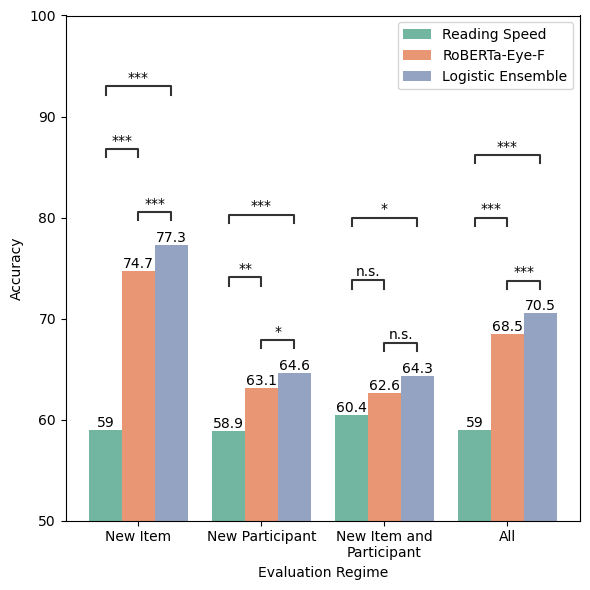

In [25]:
# Define consistent colors for each model
colors = ["#66c2a5", "#fc8d62", "#8da0cb"]
# colors = ['#1b9e77','#d95f02','#7570b3']
# colors = ['#a6cee3','#1f78b4','#b2df8a']
model_color_map = {
    "Reading Speed": colors[0],
    "RoBERTa-Eye-F": colors[1],
    "Logistic Ensemble": colors[2],
}

plt.figure(figsize=(6, 6))
# Create the plot
bars = sns.barplot(
    data=ensemble_exp_results_for_plot,
    x="eval_regime",
    y="accuracy",
    hue="Model",
    palette=model_color_map,  # Apply the color mapping here
)
bars.bar_label(bars.containers[0])
bars.bar_label(bars.containers[1])
bars.bar_label(bars.containers[2])


pairs = [
    [("New Item", "Reading Speed"), ("New Item", "Logistic Ensemble")],
    [("New Participant", "Reading Speed"), ("New Participant", "Logistic Ensemble")],
    [
        ("New Item and\nParticipant", "Reading Speed"),
        ("New Item and\nParticipant", "Logistic Ensemble"),
    ],
    [("All", "Reading Speed"), ("All", "Logistic Ensemble")],
    [("New Item", "RoBERTa-Eye-F"), ("New Item", "Logistic Ensemble")],
    [("New Participant", "RoBERTa-Eye-F"), ("New Participant", "Logistic Ensemble")],
    [
        ("New Item and\nParticipant", "RoBERTa-Eye-F"),
        ("New Item and\nParticipant", "Logistic Ensemble"),
    ],
    [("All", "RoBERTa-Eye-F"), ("All", "Logistic Ensemble")],
    [("New Item", "RoBERTa-Eye-F"), ("New Item", "Reading Speed")],
    [("New Participant", "RoBERTa-Eye-F"), ("New Participant", "Reading Speed")],
    [
        ("New Item and\nParticipant", "RoBERTa-Eye-F"),
        ("New Item and\nParticipant", "Reading Speed"),
    ],
    [("All", "RoBERTa-Eye-F"), ("All", "Reading Speed")],
]


annotator = Annotator(
    bars,
    pairs,
    data=ensemble_exp_results_for_plot,
    plot="barplot",
    x="eval_regime",
    y="accuracy",
    hue="Model",
    palette=model_color_map,
    # order=list(model_color_map.keys()),
    order=["New Item", "New Participant", "New Item and\nParticipant", "All"],
)
pvalues = pvals[0] + pvals[1] + pvals[2]
# put the pvlues inside the plot
annotator.configure(line_height=0.01)
annotator.set_custom_annotations(
    text_annot_custom=[nu.map_pvalue_to_asterisks(p / 2) for p in pvalues]
)
annotator.annotate(line_offset_to_group=0.03)
# Set limits and labels
plt.ylim(50, 100)
plt.ylabel("Accuracy")
plt.xlabel("Evaluation Regime")

# Set legend location
plt.legend(loc="best")
plt.tight_layout()
# Save the figure
plt.savefig("figures/ensemble_exp_results.pdf")
plt.show()